This program fits a 'data' with a combination of two given end spectra, 'octa' and 'tetra'.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.optimize as op
from pylab import *
from scipy.interpolate import interp1d
import helper as fun
#%matplotlib notebook



import subprocess
import pandas as pd
import shutil


In [2]:
#create lists for each columns
energy_oct = []
octa0 = []
energy_tet = []
tetra0 = []

#read the reference spectra from a file and append to respective lists
for i in open('endspectra.txt', 'r'):
    segs = i.split()
    energy_oct.append(float(segs[0]))
    octa0.append(segs[1])
    energy_tet.append(float(segs[2]))
    tetra0.append(segs[3])

In [3]:
directory = 'Data'
# checks that the directory exists and throws error if not
assert os.path.exists(f'{directory}/'), f'No directory with the name {directory} in current folder'
file_list = [f for f in os.listdir(directory)]
N = len(file_list)

# Data will be a 3D list that will be [batch number, row, column]
# where the rows and columns are the same from rat trap all data files
Data = []
# Headers will list which column corresponds to which property, i.e. energy or counts per live
Headers = []

# read in every data file
for filename in file_list:
        Data.append(np.array(fun.read_alldata_file(f'{directory}/{filename}'))) 

# convert list to array
Data = np.array(Data, dtype=float)


In [4]:
#give a list of names for legend
leg_list = ['1m + 0.5m @ 150°C', '1m + 0.5m avg @ 25°C', '1m + 0.5m @ 25°C']

Fractional contribution of Octahedral spectrum = [0.37035503]
Fractional contribution of Octahedral spectrum = [0.64877155]
Fractional contribution of Octahedral spectrum = [0.64462342]


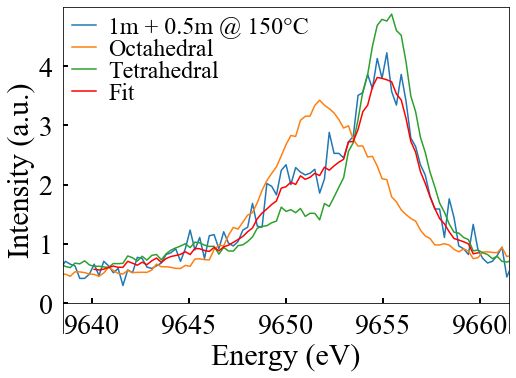

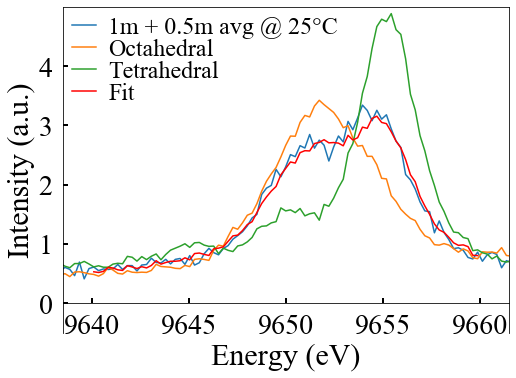

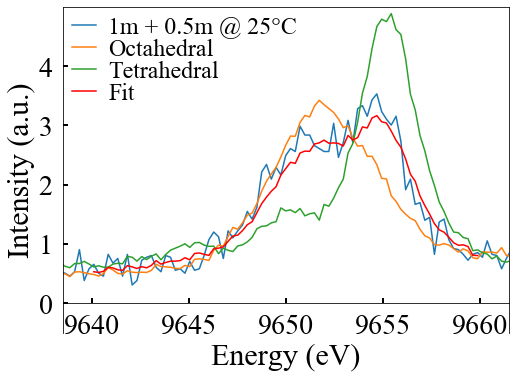

In [5]:
for i in range(len(file_list)):
    energy0 = Data[i,:,0] # eV 
    data0 = Data[i,:,1]
    energy0 = energy0.tolist()
    data0 = data0.tolist()

    #interpolate the end spectra into the energy grid of data to fit
    energy1, octa1, tetra1, data1 = fun.interpolate(energy_oct, octa0, energy_tet, tetra0, energy0, data0)
    
    #specify the start and end of fitting range in energy
    start_fit, end_fit = fun.get_index(energy1, 9640, 9660)

    #clip the arrays to select the region to fit
    energy = energy1[start_fit:end_fit]
    octa = octa1[start_fit:end_fit]
    tetra = tetra1[start_fit:end_fit]
    data = data1[start_fit:end_fit]
    
    coeff = 0.5
    
    starting_param_vals = np.array([coeff])

    # perform minimization routine
    # minimize(error_function_name, parameter_array, args=(extra inputs for error function))
    optimized_fit = op.minimize(fun.loss, starting_param_vals, args=(octa, tetra, data), method='BFGS')
    #print(optimized_fit)
    coeff = optimized_fit['x']
    
    fit = fun.model(coeff, octa, tetra)
    #this is the residual: difference between the fit and data
    residual = ( fit - data)

    # Presentation
    print(f"Fractional contribution of Octahedral spectrum = {coeff}")
    
    fun.write_to_file(energy, fit, residual, f'{file_list[i]}')
    
    fun.plot(energy1, data1, octa1, tetra1, energy, fit, residual, f'{leg_list[i]}', f'{file_list[i]}-new')